In [318]:
import streamlit as st
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
# from textblob import TextBlob
import collections
# import seaborn as sns
# from sklearn.feature_extraction.text import TfidfVectorizer
# from collections import Counter
import json
import plotly.express as px
import re

import spacy
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
#if needed, download necessary libraries for pos_tagging, lemmatizer, etc
# import nltk
# nltk.download('wordnet')
# nltk.download('brown')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

stats_filepath = "data/01_youtubeStatsTranscripts.json"
qa_filepath = "data/02_QAOutputChatGPT.json"

out_filepath = "data/03_finalStatsAndQA.csv"

with open(qa_filepath, 'r') as f:
    qa_json = json.load(f)

with open(stats_filepath, 'r') as f:
    youtube_json = json.load(f)
    
category_dict = {
    1:"Film & Animation",
    2:"Autos & Vehicles",
    10:"Music",
    15:"Pets & Animals",
    17: "Sports",
    18:"Short Movies",
    19:"Travel & Events",
    20:"Gaming",
    21:"Videoblogging",
    22:"People & Blogs",
    23:"Comedy",
    24:"Entertainment",
    25:"News & Politics",
    26:"Howto & Style",
    27:"Education",
    28:"Science & Technology",
    29:"Nonprofits & Activism",
    30:"Movies",
    31:"Anime/Animation",
    32:"Action/Adventure",
    33:"Classics",
    34:"Comedy",
    35:"Documentary",
    36:"Drama",
    37:"Family",
    38:"Foreign",
    39:"Horror",
    40:"Sci-Fi/Fantasy",
    41:"Thriller",
    42:"Shorts",
    43:"Shows",
    44:"Trailers"
}
lemmatizer = WordNetLemmatizer()

extra_stopwords={"job", "occupation", "work", "career", "not", "specified", "N/A",
                "pursue", "wanted", "to", "as", "full time", "currently", "work", "career", "time", "working", "poster", "job", "wa", "something", "pursue",
                "video", "new", "full", "N", "feeling", "take", "formerly",
                "um", 'uh', 'u', 'oh', 'thing','people', 'thing'}
stopwords = set(STOPWORDS)
prefix1 = "The current job/occupation of the speaker is"
prefix2 = "The former job/occupation of the speaker was"
prefix3 = "The main reason that the speaker had for quitting their job/occupation was"
full_stopwords = set(prefix1.split() + prefix2.split() + prefix3.split()) | stopwords | extra_stopwords
full_stopwords = set([lemmatizer.lemmatize(word.lower()) for word in list(full_stopwords)])
full_stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'career',
 'com',
 'could',
 "couldn't",
 'current',
 'currently',
 'did',
 "didn't",
 'do',
 'doe',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'feeling',
 'few',
 'for',
 'former',
 'formerly',
 'from',
 'full',
 'full time',
 'further',
 'get',
 'ha',
 'had',
 "hadn't",
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'itself',
 'job',
 'job/occupation',
 'just',
 'k',
 "let's",
 'like',
 'main',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself'

In [44]:
nlp = spacy.load('en_core_web_sm')


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jonathanchan/nltk_data...


True

In [3]:
#process youtube_stats_and_transcripts into stats dataframe

# with open(stats_filepath, 'r') as f:
#     youtube_json = json.load(f)
youtube_df = pd.DataFrame(youtube_json)
youtube_df['viewCount'] = pd.to_numeric(youtube_df['viewCount'], errors='coerce')
youtube_df['likeCount'] = pd.to_numeric(youtube_df['likeCount'], errors='coerce')
youtube_df['commentCount'] = pd.to_numeric(youtube_df['commentCount'], errors='coerce')
youtube_df['categoryId'] = pd.to_numeric(youtube_df['categoryId'], errors='coerce')
# youtube_df['categoryId'] = youtube_df['categoryId'].astype(str)
youtube_df['categoryId'] = youtube_df['categoryId'].apply(lambda x: category_dict[x])
youtube_df = youtube_df.fillna(0.0)

youtube_df = youtube_df.rename(columns={"categoryId": "categoryName"})

#Create list of transcripts - joined using periods between timestamped lines
transcripts_list = youtube_json['transcripts_raw']
transcripts_joined = [". ".join(x) for x in transcripts_list]

In [230]:
def create_qa_df(in_json):
    """Return a dataframe with processed text for curr job/former job/quitting reason"""
    
    #process_qa
    video_ids = []
    curr_jobs = []
    former_jobs = []
    main_reasons = []
    for video_id, text in in_json.items():
        video_ids.append(video_id)
        curr_job = None
        former_job = None
        main_reason = None
        text = re.sub('\d\.', '', text)
        text = text.replace("\n", "")
        text_list = text.split(".")
        if '' in text_list:
            text_list.remove('')
        if len(text_list) == 3:
            curr_job = text_list[0]
            former_job = text_list[1]
            main_reason = text_list[2]
        else:
            for i, sent in enumerate(text_list):
                if 'current' in sent:
                    curr_job = sent
                if 'former' in sent:
                    former_job = sent
                if "main reason" in sent:
                    main_reason = " ".join(text_list[i:])
                else:
                    main_reason = text_list[-1]
        curr_jobs.append(curr_job)
        former_jobs.append(former_job)    
        main_reasons.append(main_reason)
    #     print("---")
    qa_dict = {
        "videoId": video_ids,
        "curr_job": curr_jobs,
        'former_job': former_jobs,
        'main_reason':main_reasons
    }
    qa_df = pd.DataFrame(qa_dict)
    
    return qa_df



,tags,channelId,channelTitle,categoryName,publishedAt,title,videoId,viewCount,likeCount,dislikeCount,commentCount,favoriteCount,description,transcripts_raw,transcript_strings,curr_job,former_job,main_reason
0,No Tags,UCCFodX6dcHPnkcNkyOkjRLA,Chris Cascella,People & Blogs,2021-09-07T22:30:00Z,Why I Quit my Job With No Backup Plan | The Pe...,PgfzN1xfgLc,293930.0,14566.0,Not available,1507,0,Apply for Life & Mindset Coaching: https://www...,"[what's up everyone welcome to the video, toda...",what's up everyone welcome to the video today ...,The current job/occupation of the speaker is...,The former job/occupation of the speaker was...,The main reason that the speaker had for qui...
1,"[i quit my job, quit job, i quit, adulting ser...",UC-4yhaT7ECHCM37EKuMGHeg,iris wellen,People & Blogs,2023-05-07T15:00:13Z,i quit my job.,NhVg9qdHWiY,15036.0,711.0,Not available,185,0,"so, i made this huge life decision: i quit my ...","[[Music], thank you, foreign, [Music], I don't...",[Music] thank you foreign [Music] I don't even...,The current job/occupation of the speaker is ...,The former job/occupation of the speaker was...,The main reason that the speaker had for qui...
2,"[Quit my job, Great Resignation, Self Employed...",UC9SLXh5V1bwFiS82DTRUx8A,Austin Williams,Howto & Style,2023-03-27T13:00:04Z,"i quit my job, and it was the best decision of...",6ecjnRHt5l8,21018.0,1898.0,Not available,284,0,It's been quite the journey on my march to fre...,"[ladies and gentlemen damusicaviro's 100, vide...",ladies and gentlemen damusicaviro's 100 videos...,The speaker's current job/occupation is YouTuber,The speaker's former job/occupation was a hi...,The main reason that the speaker had for qui...
3,"[i quit my job, i quit my corporate job, quit ...",UCYVHKVS0lrujpO06LmuflKQ,TotallyMeagan,Howto & Style,2022-08-29T20:40:36Z,I QUIT MY CORPORATE JOB FOR MY MENTAL HEALTH,qfJlP8VhYDg,20949.0,1168.0,Not available,325,0,In this video I share more about what is going...,"[i quit my job for my mental health, i feel so...",i quit my job for my mental health i feel so c...,The speaker's current job/occupation is conte...,The speaker's former job/occupation was a cu...,The main reason that the speaker had for qui...
4,"[i quit my job, quitting my job, why i quit my...",UCPa0bvFsR1mbBpk5mIPFGLA,Vincent Chan,Education,2022-07-07T14:00:06Z,Quitting my job was a big mistake,84FPm7oAQG8,554529.0,18422.0,Not available,1163,0,Go to https://bit.ly/3QcW39t and use code VINC...,"[I have a confession I was wrong so I, gained ...",I have a confession I was wrong so I gained so...,N/A,N/A,The main reason that the speaker had for quit...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,"[Business, DIY, Entrepreneur, Quit my job, Ele...",UCPz9akaMbffvxELBRlemUjA,Cory Mac - ØY Electrical,People & Blogs,2022-08-04T17:00:14Z,I’ve Quit My Job To Start a Business! | ØY01,QkulkvymaT4,102401.0,6115.0,Not available,938,0,"I’ve just quit my job, let me explain why, and...","[it now costs over 95 pounds to fill an, avera...",it now costs over 95 pounds to fill an average...,N/A,N/A,N/A
995,No Tags,UCp5C_jdFWNdn6EOVaH9KB5w,Our Bipolar,People & Blogs,2021-03-09T14:40:18Z,I Had To Quit My Job Because of Bipolar,nEJpTe6zGPE,5819.0,138.0,Not available,43,0,Today’s vlog is about that time I had to quit ...,"[hi everybody it's jessica notes with our, bip...",hi everybody it's jessica notes with our bipol...,N/A,N/A,N/A
996,"[abraham hicks, abraham hicks meditation, mani...",UCV9MdPShDjMJ2JBi7l5tGZg,Knowledge of Abraham,Education,2021-04-29T17:30:00Z,"I Want to QUIT My Job, But I Am Scared... Abra...",H3Y7N8h-lbY,7733.0,332.0,Not available,19,0,A lot of people want to quit their job and wal...,"[i've had this amazing career, and it's been f...",i've had this amazing career and it's been fun...,N/A,N/A,N/A
997,"[kelvin learns investing, i quit my job, i qui...",UCJmaaSJX_PkfUmTuxWbrzLw,Kelvin Learns Investing,Education,2023-03-17T00:00:30Z,I Quit My Job After Learni

In [223]:
# test_transcript = full_df['transcripts_raw'].tolist()[6]
# for sent in test_transcript:
#     sent_blob = TextBlob(sent)
#     print(sent_blob.sentiment.subjectivity)

In [212]:
def get_pos_words(in_str, pos_list=["JJ", "JJR", "JJS"]):
    """Returns a list of words extracted from in_str with any words included in pos_list. Function will lemmatize words
    and remove words that are in full_stopwords or not alphanumeric
    
    assume pos_list contains all POS tags as individual strings - 'JJ' and 'JJR' must be included to get both POS tag words
    """
    tokens = word_tokenize(in_str)
    tokens_lemm = [lemmatizer.lemmatize(word.lower()) for word in tokens]
    tokens_filt = [word for word in tokens_lemm if word not in full_stopwords and word.isalnum()]
    pos_tags = nltk.pos_tag(tokens_filt)
    filt_tags = [tup for tup in pos_tags if tup[1] in pos_list]
    filt_words = [tup[0] for tup in filt_tags]

    return ". ".join(filt_words)
    
test_str = full_df['transcript_strings'].tolist()[2]
# adv_tags=['RB', 'RBS', 'RBR']
adj_tags=['JJ', 'JJR', 'JJS']
noun_tags=['NN', 'NNS', 'NNS', 'NNPS']
get_pos_words(test_str, noun_tags)

'gentleman. mom. star. channel. view. hour. watch. subscriber. translate. vietnamese. lot. dollar. cent. look. picture. thing. number. process. page. clip. hour. hour. dozen. book. money. money. thing. process. youtube. life. life. life. experience. journey. lifetime. year. half. month. kind. reflect. decide. chance. life. bit. lesson. reward. someone. chance. life. experience. seek. life. life. lesson. youtube. lesson. channel. age. dollar. year. life. waking. weekend. remember. adult. world. life. experience. money. woke. person. day. adult. life. money. security. stop. path. start. money. opportunity. security. life. lesson. lesson. need. anything. camera. function. camera. thing. youtube. anybody. decent. mean. ask. see. progress. bit. look. camera. sound. anything. life. gon. prevent. life. matter. step. people. people. process. learn. process. lesson. favor. view. effort. result. month. half. week. dog. house. book. alchemist. quote. continue. journey. path. heart. journey. light

In [210]:
def get_noun_chunks(in_str):
    """Return list of noun phrase strings from in_str. Filter chunks that are only composes of stopwords in full_stopwords - 
    do not remove stopwords if the chunk contains interesting keyword as well"""
    nlp_obj = nlp(in_str) #creates noun chunks
    chunks_raw = [str(chunk) for chunk in nlp_obj.noun_chunks]
    chunks_filt=[]
    for chunk in chunks_raw:
        words = word_tokenize(chunk)
        all_stopwords = True
        for word in words:
            word_cleaned = lemmatizer.lemmatize(word.lower())
            if word_cleaned not in full_stopwords:
                all_stopwords = False
        if not all_stopwords:
            chunks_filt.append(chunk.lower()) #append without lemmatizer - those are just used to check
        else:
            pass
    return ". ".join(chunks_filt)

    
get_noun_chunks(test_str)

"ladies. gentlemen. my mom. mama i'mma. a star. a melagosteen. 100 videos. this channel. three million views. 300 000 hours. watch time. 45 000 subscribers. augustin. vietnamese dong. well a little over 597 million vietnamese dong. a lot. fur. us dollars. the big picture. one thing. those numbers. a slow process. so much work. those hundred videos. four to five hundred pages. over 400 clips hundreds. hours. hundreds. hours. dozens. books. decent money. honest money. the least significant thing. this process. youtube. my life. my life. my life. this experience. a journey. a lifetime. the last year. a half. the last seven months. a chance. life. the lessons. any financial reward. someone. a chance. life. my lessons. this experience. your best life. 10 life lessons. youtube lesson one. this youtube channel. my first adult job. age. forty eight thousand dollars. the first time. my life. this routine. the weekends. this high paying adult job. the world. so many different life experiences. t

In [237]:
adj_tags=['JJ', 'JJR', 'JJS']
noun_tags=['NN', 'NNS', 'NNS', 'NNPS']

for i, row in full_df.iterrows():
    
    curr_transcript = str(row['transcript_strings'])
    former_job = str(row['former_job'])
    main_reason = str(row['main_reason'])

    transcript_adj = get_pos_words(curr_transcript, adj_tags)
    transcript_nouns = get_pos_words(curr_transcript, noun_tags)
    transcript_nc = get_noun_chunks(curr_transcript)
    reason_nc = get_noun_chunks(main_reason)
    job_nc = get_noun_chunks(former_job)

#     if i == 100:
#         break
#     print(transcript_nc)
#     print("---")

everyone. a backup plan. a lot. this decision. my thought process. any big decision. life. time stamps. the description. 's. my own boss. college. a finance degree. so many other people. a pile. student loan debt. top. my life. graduation. a big company. corporate finance. a resume. the people. a lot. high school. the dreams. my first thought. a conversation. a close friend. mine. my situation. my first impulse. six months. a new role. the company. an entirely different state. new responsibilities. the hope. things. a renewed sense. excitement. this new role. the people. this point. my mind. money. this point. my student loans. the money. a steady paycheck. the people. great relationships. their plates. the third thing. this one. the uncertainty. a big part. the fact. my next paycheck. things. people. a living. honestly just the overall fear. that point. my entire life. school. college. 65 or whatever age. the idea. a leap. that structure. these fears. months. a conclusion. my perspect

my mental health. megan. a live update. this stuff. the title. all that good stuff. 's. a really hard video. a lot. this decision. the last month. a show. a good place. migraines. nervous sweat. i majority. the issues. the beginning. our team. a posi. a place. a few people. a difficult time. our team. way more people. top. our busy season. our busy season. just a naturally busier time. just a lot. the knowledge base. that team. that department. more training. more help. the amount. people. sense. the ground. the ground. stuff. the ground. my resume. my budget. my savings. my family. another one right. enough money. savings. my budget. my spreadsheet. my budget. that stuff. about seven months. expenses. good seven months. different things. the point. person. team. meetings. stuff. place. the knowledge. the way. everybody. the point. my two weeks notice. another one. weeks. my parents. my parents. you guys. my mom. my mom. those people. your mental health. that sort. thing. my parents. m

my position. a pleasure. the spirit. honesty. linkedin kind regards. kids. a little um gem. people. all heroes. my part. you guys. the word. kick-ass. three parts. the first part. a lecture room. the first part. my story. my story. the five or six things. between six bullet points. six things. the last part. the end. the structure. my story. this company. four years. that company. la. the promotion. another three years. another promotion. that part. your flowers. more money. the most important thing. just my mental health. a really hard time. that year. last year guys. a terrible time. my personal life. a person. that doubt. my options. this show. my plan. no clue. this decision. the things. things. my five points. some point. the next five points. this point. a decision. number. four years. my company. four years. no clue. the the fear. six months. a year. this decision. scared fear. a given fear. a given fear. this decision. send. that resignation. my laptop. another. another day. so

the norm study. the career ladder. a fat salary. sense. all these things. our life. someone else's rules. so many different paths. your own path. your own lifestyle. my high paying job. my 20s. your passion. a full-time job. your growth. the self-employed life. everyone. not a day. my own boss. this idea. good grades. uni. different things. 10 different jobs. the job description. a right fit. the job descriptions. none. these job descriptions. a right fit. the bullet. a weird feeling. today. my identity. a category. a generalist. a problem. a problem. the interest. the corporate leather. a shiny role. a design director. head. design. a company. the answer. a clear idea. that realization. my ideal lifestyle. things. full control. a full-time job. useful things. people. a life. no so-called job scope. things. energy. morning. midnight. the life. a full-time job. my life. complacency. a drop. performance. stagnant growth. action. the exception. your face. challenges. stress. other areas. 

[music] foreign [music] nature. peacocks. the background. no introduction. my perfect job. you guys. warner bros discovery. the past. my first corporate job. college. many first stairs. home. office. my first promotion. many cool experiences. warner bros 100th anniversary. a lifetime. my team. the experience. stuff. cool people. cool events. a lifetime experiences. the perfect job. staple income exciting environment work life balance. the list. everything. my learning curve. my perfect situation. sense. perfection. quite a while. an overnight decision. a whim. an easy one. my commitment. my goal. the company. things. right patience. a virtue. patience. an excuse. patience. the poison. your dreams. patience. way. the cost. my precious time. finite time. our scarcity's resource. no way. the most optimal advantageous beneficial decision. a cross analysis. 10 questions. each decision. 20 questions. my most honest answer. either decision. a very first shot. biased decisions. decisions. my e

guys. my channel. you guys. the title. a week. a full week. anyone. my family. guys. anyone. my footing. my decision. any opinions. you guys. you guys. just my journey. our journey. you guys. college. this year. you guys. every single every single comment. you guys. this position. you guys. the fact. you guys. a part. this journey. you guys. the entire process. the day. _. my last day. guys. that entire journey. guys. a very dramatic video. a lot. tears. a lot. emotions. doubts. fears. this decision. you guys. this journey. you guys. my plans. the future. this channel. 's. guys. everything. _. a point. balancing content. my work environment. the only person. color. my team. someone. the other person. color. the team. coffee. my manager. the the environment. a good work environment. the level. stress. our team. people. my team. midnight. emails. the morning. people. this expectation. a lot. hours. anything. the main thing. the number one thing. this company. amazon. you guys. amazon. aw

foreign [music. noon. 1 p.m. my bed. a special day. a few changes. my full-time job. a full-time content creator. podcaster. that decision. a decision. my internship. a full-time job. a lot. insight. my youtube. my podcast. a full-time job job. my youtube. my instagram. content creator space. also the podcast. the world. three different things. my reality. the past. three to four months. bed. two or three a.m. order. three jobs. my full-time job. my own youtube. the podcast. a lot. care. a good meal. a walk. a voice. the fact. a nine to five job. no bittersweetness. this moment. quite a bit. the gym. a yoga class. my body. my body. care. guys. the outside. the one. your eyes. care. the inside. the outside. trilogy. a new zealand-based brand. a pioneer. expert. sustainable and clean beauty products. the vitamin c booster treatment. my skin. glowy. the most potent form. vitamin c. my skin. the maximum results. their microbiome complexion. serum. their ultra hydrating face cream. trilogy.

a bar class. my hair. my contacts. bar. my hair. air. a pretty busy work day. two calls. another one. 's. this call. you guys. you guys. the title. people. social media. the case. my last week. my current company. a tuesday. my last day. tomorrow. the big update. my vlogs. you guys. my current company. two years. no like bad blood. anything. summer. such a fun time. college. the entirety. my postgrad. this company. that chapter. a close. a really surreal feeling. the only corporate company. my entire your life. two years. time flies. college. freshman and sophomore year. an og. evanston. my college apartment. chicago. august. three different apartments. my evanston apartment. my apartment. river north. and then this apartment. wicker park. my life. how much things. apartments. my life. chicago. my tick tock. this community. you guys. the past two years. two years. my birthday. saturday. everything. two year mark. a whole new chapter. my life. the dramatic refreshes. new chapters. my ne

seven billion people. this world. the only one. someone. a serious problem. nobody. this cold. southern california holy moly. my nose. top. sports. your clothes. our day. 's. the goosebumps. this song. this song. [music] breakfast time. that dirt. dirt. the leaf. a realization. the other day life. the past three years. life. this super short period. things. the morning. a lot. books. podcasts. people. a dream. this path. this path. this quote. your 20s. your 30s. your 40s. school. my gap year. the truth. things. my passions. that many liabilities. the right thing. one life. things. things. the energy. the things. makeup. all interest. everything. the rest. my life. the second part. just about uncertainty. new skills. things. your passion. your purpose. a lot. people. a loser. people. the answer. things. your life. love. the company. the dream. this brand. anything. anything. a different path. guys. other people. seven billion people. this world. the only one. someone. my last video tru

a recent video. my notice. the future. any more details. a vague assertion. any solid plans. eggs. any solid plans. the decision. this one. the context. a a bike ride. a beautiful sunny saturday morning. biking. camping. the things. this channel. some semi-personal aspects. my life. the gear reviews. the witty trail bands. this one. the rest. music. little sort. a living. the next couple. weeks. right code javascript. such details. one flavor. another. 20 years. the lifestyle. the last decade. my surprisingly popular biggest danger. bike packing video. go. a good one. the views. the moment. my accidental career. cycling. an adult. my first ever multi-day ride. the decision. freelance. more multi-day rides. real life. inverted commas. shelter. the spreading problems. a permanent position. today. real life. frank. an honest examination. my life choices. that point. cycling. every aspect. my life. the things. the fact. those first couple. years. a beautiful swedish girl. louise. those mee

most men. lives. quiet desperation. the grave. songs. quote. the story. gym launch. alex. that quote. the side. a business. a business. an interview. someone. gymlaunch. alex. anyone. that spot. the story. the decision backtrack. college. a degree. exercise science. college. call. man. college. a degree. exercise science. a personal trainer. people. their lives. business. business. two things. my dad. his life. a business. more entrepreneurship. people. my dad. many others. all the things. people. these roles. golden handcuff people. a town. the life. one thing. this life. my full potential. right. the first thing. all these people. a town. people. the local pub. the local bar. tv. hours. the weekends. the first reason. college. a traditional job. the second reason. the first year. college. my path. a physical therapy. tent. whatever. the most high-paying job. some experience. my own clinics. kind of the thought. a woman. the head. a clinic. college. my mind. six years. 85 grand dude. 

two friends. john. jane. the same town. their dreams. aspirations. different paths. success. john. a firm believer. the traditional route. success. the default path. a prestigious degree. a high paying job. a well-known company. the corporate ladder. paper. all a high salary job security. social status. jon. emptiness. dissatisfaction. night. jane. the pathless path. a journey. twists. turns. uncertainty. the conventional route. various career paths. projects. her values. a growth mindset. an entrepreneur. a social enterprise. underprivileged communities. jane's career. anything. a deep sense. fulfillment. purpose. a difference. the world and living life. her own terms. these two things. the default path. the pathless path. the concepts. paul millard. this book. the pathless park. a story. a new story. life. the subject. this episode. book club. the ongoing series. three years. my favorite highlights. my favorite books. the most impactful books. the terminology. a few mental models. al

a mid tier lawyer. a big 4 law firm. singapore. over
6 years. my guts. a nice 6 figure salary. the eyes. my parents. the people. the
motions. day. the colleagues. fact. the whole thing. a pretty toxic work culture. u. stuff. the world. america. this
thing. the great resignation. people. the towel. droves. so many different reasons. an easy decision. the turning point. 3 things. money. first, the whole job-salary configuration. a money trap. kinda. a
rat trap. u. u. your salary. the end. the month. your bills. your life. the thing. money. the end. every month. financial problems. the limited time. us. most salaried employees. the only source. income. exactly the case. the configuration. a trap. your life. inspiration. all that good stuff. u hv. your own businesses. income streams. all that good stuff. other people’s businesses. companies. that salary. my second realisation. money. that money. even a lot. an adequate compensation. us. a value
judgement. an individual hv. your specific jo

hey y'. stivers homestead. the previous video. this one. chocolate milk. oranges. our comparison. the not the denali beast dehydrator. about 17 18 ish hours. all the oranges. my lip. two full quarts. dehydrated oranges. around 27 hours. the milk. a full quart. chocolate milk. us. the freeze. dried food. just a little bit. chocolate milk. milk. a tablespoon. powder. a tablespoon. water. a minute. just a second. our powdered cow's milk. basically a regular basis. the most part. the fridge. the residue. the water. the look. the fridge. 's. us. cocoa powder. some milk. chocolate milk. chocolate milk. a great success. the freezer. that freeze-dried zucchini. jen. her zucchini bread. the world's best zucchini bread period. the next day. another beautiful day. kentucky. the jen's favorite line. bottom. my uh dad joke. sayings. a lot. the bottom. a nice window open day. jen. a killer breakfast. film. the finished product. her homemade bread. thaw. bread. the fridge. french toast bake. those th

hey guys. an adventure. fifth water hot springs. my adventures. eight years. tv news. an adventure. news. tv news. an amazing journey. the skills. youtube. a reporter slash anchor. almost a decade. 's. the biggest drawbacks. so many people. news. the news. a reporter. a family member. their son. daughter. those stories. those interviews. part. this great resignation. people. quality. life. pay. example. pay. another thing. the negativity. the pandemic. my passion. satisfaction. news. my success. youtube. a journalist. news. the things. travel. a lot. these trips. the channel. engaging content. the field boots. the ground. you guys. the perks. the channel. flexibility. my schedule. a lunch break. beautiful things. heck. the water. bikini bottoms. a huge scab. my knee. a huge scab. my knee. water. a chance. the hot spring. my scab. the hot spring. a great backdrop. my reasoning. eight years. tv news. youtube. that content. a lot more fulfilling. 's. the news. those stories. some people. 

everyone. another video. today. a bit. a slow and sleepy start. the moment. our couch. my pillow. my laptop. lockdown. lockdown. south australia. a lot. meetings. the day. concentrate. stuff. all the things. some cocoa. you guys. my recent vlogs. lots. lots. cocoa. green tea. character. the moment. adelaide. cocoa. sacrilege. those people. hot water. coco. those kids. hot water. milos. a tiny amount. milk. the way. a chocolatey malt sort. my friend's house. my early teens. their milos. milk. cocoa. any sort. hot chocolatey drink. milk. the whole thing. 's. the almond milk. a bad angle. my apartment. the genuine chaos truth. a very very messy person. things. a mug. almond milk. then a teaspoon. a teaspoon. a half. sugar. a teaspoon. a bit. cocoa. a pot. the whole thing. my cocoa recipe. the moment. the weather. the moment. a good genuinely chilly day. summer. this apartment. the nice chilly cozy weather. a lot. vitamin a. iron. the mindset. the same nine to five hours. the transition. t

a race. my name. the core. the person. the same life. these questions. the best thing. the best things. this world. this road. hey guys. my job asmr. a move. the title. my journey. a lawyer. my new role. two months. a doubt. a very intentional step. social media. a lot. any kind. consistent narrative. things. some kind. life milestone updates. my coming out story. my room redecoration story. new lampshades equal life mashed stones. share. a channel. my qualification. a lawyer. the future. the challenges. my life. a lot. life. experience. vulnerability. all the stuff. this channel. a re. -. introduction. my new chapter. the internet. a bit. an essay. my previous self. decisions. a trainee solicitor. people. my training contract. my experience. the incredible lawyers. complete gratitude. zero regrets. my training contract. my second year. the university. bristol. five years difference. a lot. change. a lot. evolution. growth. five years. your priorities. my mental health. more weeks. the

ladies. gentlemen. my name. my channel. the title. this video ladies. gentlemen. a big life decision. home videos. youtube videos. the point. the best way. youtube full-time. the camera. a lot. just things. the last couple years. a lot. the things. life. money. my life. college. my summers. a minimum wage job. home. money. over ten thousand dollars. one year. college. the peace corps. a couple videos. many videos. that much money. those years. my life. the money aspect. the experience aspect. such great memories. the pandemic. my life. a lot. people. a kind. transition. my life. college. a kid. the peace corps. those people. a calling. a certain thing. certain job. a doctor. my whole life. an adult. this lifestyle. colorado. my first adult job. forty seven thousand dollars. more money. more money. that point. my life. over ten thousand dollars. one year. a good job. great benefits. low stress. great co. -workers great boss. any fulfillment. the problem. this space. a big space. a remot

georgia honey. the morning. the morning. the road. macon. my last orthodontist appointment. y'. all my invisalign. four more months. invisalign. the orthodontist office. y'. the chapstick. your mouth. a long time. your lips. all that water. stuff. those ugly brackets. whatever. my teeth. the same shade. my teeth. y'. my teeth. his teeth. the brackets. brackets. my teeth. your teeth color. my teeth. my teeth. y'. my teeth. the brackets. my teeth. my teeth. all my stuff. our clients. the one. the widest smile. invisalign braces. anyone. february. my consultation. january. sets. whatever. february. january. december. december. florida. a quick turnaround. january. january. all their equipment. this look. this big old box. their equipment. y'. this line. an orthodontist appointment. home. two years. covet. us. your ratings. my ratings. your ratings. this percentage. the boot. y'. the office. y'. your rating. florida. the computer. laptop. all that stuff. two life updates. you guys. my miss

y'. paris. another video. you guys. my testimony. god. guys. a fun journey. a lot. a lot. the journey. the process. guys. case. god. god. god. the answer. whatever. the answer. money. just whatever. provision. god. my home. god. my spirit. god. a two weeks notice. god. a one week's notice. none. sense. god. this home. foreclosure. this home. one check. two weeks. a hole. one check. god. my thinking. your employer. your employer. your provider. your provider. your provider. god. my employer. all my hope. all my hope. my employer. no god. the only person. the person. your employer. god. the process. the one. god. christmas eve guys. christmas eve. one more check. problems. my home. the link. my bathrooms. the other bathroom. a shower. the water. a shower. the water. the water. my water bill. a plumber. a home warranty. the home warranty people. the plumbing service. the plumbing service. the problem. my house. the guy. my um home warranty people. the difference. y'. yay. my pocket. the l

hpvp. another mc pvp hunger games. another full day shift. normal monday. friday. nas. part-time. the math. 17 and a half thousand pounds. an entry-level job. minimum wage. a graduate. the third class honors. the math. national insurance. tax. full-time wage. 10 hour shifts. just above 10 hours. 11 hour shifts. part-time. double the time. 200 percent. the hours. the actual wage. a good investment. this thought. your wage. the extra 20 hours. businesses. online businesses. my final year. university. a few hundred pounds. three thousand pounds. my business. the profits. a day. maybe half the money. home. the comfort. your own room. your own bedroom. your heating. _. a beautiful day. a sunday. a monday. my hours. part-time. a part-time job. the best time. some kind. online business. my hopes. location independence. the world. example. thailand. cheap accommodation. builds. a business. the uk. british pounds. a significant amount. thai bat. example. my youtube videos. six times. a row. an 

all their their stuff. the laptop. footage. everything. a new vlog. footage. very old footage. everything. my life. everything. so many things. things. the way. another job. you guys. my my istqb certification. guys. the vlogs. training. vlog. a software testing certificate. my goals. this year. my dream job. the house. this vlog. guys. an update. the next vlog. dressed guys. color. the shirts. h. m. the shirts. last week. h. this beautiful pictures. these beautiful pictures. color. this summer. bright shirts. this one. mango guys. a forgive. the angles. h. this beautiful shirt. this shirt. this shirt. this one. h m. a linen linen blend. this shirt. the same pair. jeans. the same outfit. just a different color different shirt. the shoes. a lot. people. my instagram. a lot. people. hate hate. the other shirt. color. the office. the office. 30 minutes. you guys. my office. everything. my laptop bag. this guy. guys. my laptop. everything. everything. a portable wi-fi. the charger. everyth

my notice. employment. anything. hr. anything. silicon valley. the coolest offices. free breakfast lunch dinner. cool events. the dream. the dominican republic. not much money. community college. an engineer. my only real connection. the tech world. podcasts. cool office tours. a dream. a nightmare. 's. 's. a dream. my entire life. terms. two main lessons. the hard way. my days. endless loops. my day. everything. those tasks. one more day. the cycle. my work days. the only places. ease. a bathroom. my phone. the outside world. my legs. kind of funny thinking. an imposter. all my life. the safer paved route. things. college studying engineering. an internship. college. a network. people. college. a lot. money. my parents. an amazing situation. that sacrifice. top. the finances. that fire. rocky hidden path. all the risks. my emotions. thoughts. procrastination. time management. spoiler alert. anything. front. my laptop. my email page. an email. my company. just a simple email. the safes

a full-time artist. no hair. a dream. such a wild roller coaster. emotions. nasty noises. my dream job. a wild few weeks. months. hon. beedley. beefy. the fact. that buddy. a graphic designer. this company. six years. the people. the people. a smaller business family-owned business. a really good job. my business. three years. two jobs. three years. my own small art business. my full-time graphic design job. a long time. a struggle. a long time. my art career. my toes. an accidental nipple. buddy. a long time. my wife. her own business. help. that stuff. three jobs. a point. anything. the situation. a great full-time job. my business. my wife's business. everything. the amount. a little baby puppy. the mix. quite the time-consuming thing. my life. my life. so many different ways. buddy bindi. her life. the princess. the house. energy. a person's energy. a certain amount. energy. things. a certain extent. a long time. a couple weeks. your body. breaks. my art. my wife. her business. tho

costa rica. no secret. no secret. a significant time. your adult life. no secret. a sabbatical a career break. recount. the stories. my year. a year. savings. some resources. a career break. many a mini retirement. good morning friends. 's. my um thing. y'. my entire gap year. selfies. a bunch. pictures. this good morning. mom. 's. my mom. 72 degrees. exotic dover delaware. the sunba. southern rose tia d good morning friends. my comments. acting janky. okay good morning. real slow good morning caddy wagon. kay good morning profess lch good morning. latasha. our black utopia. seven months. things. a full picture. my seven year job. adversary. the difference. my usual scroll. your comments. the summer. the summer. the lessons. black women. a sabbatical right. over 30 black women. purpose. purpose. whatever. disability. 30 women. that place. some free time. their adult years. the good years. june. lessons. my own gap year. other things. sitting. youtubing. other things. compliments. the c

japan. naraijuku. an old post town. the nagacendo. the main road. a small side street. this small little shrine. any better place. japan. my history. the company. a senior software architect. apps. september. that same year. a dev lead dev. more responsibility. not just one platform. android. ios. the whole team. my case. my responsibility. addition. the ones. the situation. the whole team. the department. the company. the customers. a little bit. conflict. the decisions. my manager. a manager. a possibility. his position. 's. course. things. my manager. his position. his manager. the upper management. a hundred percent. board. a manager. training. a manager's job. the full manager's powers. also not the manager's pay. hindsight. the best situation. a team. the credentials. credibility. a manager. the situation. hindsight. a manager. power. a title. manager. the team. six months. a real manager. a manager's title credentials. the beginning. course. corona. the whole work. home. a situa

my hr. my resignation notice. my last day. one thing. a big weight. my shoulders. 10 years. my life. you guys. saturday. the last time. my last day. the last 10 years. the pleasure. really good people. the pleasure. some really good supervisors. my life. a new path. a position. full-time. the end. somebody. the end. some entrepreneurial work. a few ideas. the road. my resignation. nothing. a lot. companies. a lot. workplaces. a lot. hours. nothing. this opportunity. a roof. my head excellent benefits. nothing. shock. you guys. november 23rd. this year. a couple factors. a role. that decision. the decision. my job factor number one. my financial standing. a whole. my retirement. my savings. investments. a point. my life. everything. my monthly expenses. my retirement. factor number one factor number. the success. my youtube channel. you guys. just amazing support. a point. my life. care. my monthly expenses. youtube. guys. the bottom. my heart. your support. the world. guys. guys. the b

your girl crystal tv. no chat. y'. this video comment. my channel. anywho. 's. the nitty-gritty. this whole little video. the cat. the bag. a little sketch. my opinion. 's. this somewhat. a story time. the heck. 's. april april. my birthday month. you guys. instagram. my best life. tulum mexico. vacation. this point. the burden. the pressures. people. the changes. my husband. just how maybe more um more just irritable and just different things. an increase. stress. co. -. workers. the co. -. worker. this point. then another co. -. worker. a week. this point. my caseload. maybe 20s. 20s. a therapist. a lot. emotional capacity. emotional work. someone. different issues. concerns. whatever. 45 people. quite a lot. people. people. therapists. direct counseling. so many other things. a client. a treatment plan. a client. research. clients. appointments. an agency. such a sour taste. the agency. such a great place. the beginning. covert. a huge factor. the decline. the agency. my two weeks. 

emma. a coffee shop manager. a full-time artist. an artist. my dream. a little girl. that dream. college. a normal job. my art. a manager. energy. somebody. their dreams. effort. my own art. my own business. pretty bitter working. a business. my goals. my art. my business. the mentality. enough money. the problem. all the effort. my manager position. energy. my art. my husband. my family members. my husband. my two weeks. a month's notice. a pushover. one more month. stress. that month. an end. a new type. stress. so many questions. an online course. udemy. a first-time seller. etsy. the way. the key. my success. a lot. my journey. a full-time artist. many people. etsy. etsy. a comfortable number. sales. my own website. no idea. youtube. help. wordpress. my website. my website. my website. my paintings. instagram. tick tock. over 35 paintings. painting. my head. the canvas. my paintings. tick tock. a painting. some mushrooms. a campfire. a forest. both the painting. a huge number. prin

the past two years. so many things. travel restrictions. employment situations. then 2021 so-called great resignation. life. a lifestyle. more congruent. my values. no regrets. that decision. fact. my life. anything. some people. a reckless idea. a solo parent. a child. school. a mortgage. several other expenses. a steady income. my soul. the other things. the life. almost no weekends. my son. the day. this situation. another 10 20 30 years. an escape plan. a clear strategy. the wheels. motion. my heart. my own preferred time. one. the freedom. a holiday. my son. a location. my workplace. 2010 remote work. my big break. a side job. an author. a school textbook. more than three months. a teacher. the best thing. the comfort. my own home. a cafe. a park. my laptop. my superiors. school. a resignation letter. hand. certain skills. remote work. this day. that risk. the kind. lifestyle. the financial location. time freedom. a freelancer. a more flexible schedule. shorter work hours. a weekl

my life. another job. my [music] life. your girl. daishi. some earrings. may 26th. two weeks. march 15th. two months. one week. a lot. my influencing. my social media. my content. the other things. food. you guys. a little bit. backstory. some people. your content. stuff. your old job. my old job. p.m. whatever. businesses. a doctor's appointment. a lot. free time. content. the day. sunlight. just a better schedule. holidays. holidays. holiday pay. this new position. this new position. 6 00 p.m. my life. a legit. 5 p.m. college. the mall. 10 a.m. 12 p.m. your whole entire day. healthcare. the most recent position. 12 hour shifts. four days. the week. the entire day. the weekend. things. people. the new schedule. the training. the place. a training and development background. my old job. the training manual. the entire department. all the new hires. the software. a training process. that type. the company. everything. work stuff. 8 p.m. my own things. my side. the side businesses. a lit

hello everybody. my first job. a data analyst. this youtube channel. a lot. things. the past five years. the alex. everything. the future. the script. you guys. some point. as least tears. 's. the future. a data analyst. over five years. my current company. an analytics manager. the company. a pharmaceutical distribution company. amerisourcebergum. a very good company. last week. year. my life. that kind. money. my mind. never i. 50s. 60s. my life. a data analyst. everything. my full-time job. my family. my youtube thing. these three different things. the background. these three things. the biggest reason. things. the first thing. my full-time job. my youtube thing. the youtube stuff. a lot. companies. my opinion. things. the past two years. the side. small projects. a dashboard. some pipeline. a product. their product. suggestions. my services. knowledge. the youtube content area. the past two years. the point. people. a lot. projects. a lot. those companies. a lot. those projects. th

In [240]:
#MAKE FULL_DF step 1

qa_df = create_qa_df(qa_json)
full_df = youtube_df.merge(qa_df, on='videoId', how='left')
full_df['curr_job'] = full_df['curr_job'].fillna("N/A")
full_df['former_job'] = full_df['former_job'].fillna("N/A")
full_df['main_reason'] = full_df['main_reason'].fillna("N/A")
full_df['transcript_strings'] = full_df['transcript_strings'].fillna("N/A")

full_df['transcript_nouns'] = full_df['transcript_strings'].apply(lambda x: get_pos_words(str(x), noun_tags))
full_df['transcript_adj'] = full_df['transcript_strings'].apply(lambda x: get_pos_words(str(x), adj_tags))
full_df.head()

,tags,channelId,channelTitle,categoryName,publishedAt,title,videoId,viewCount,likeCount,dislikeCount,commentCount,favoriteCount,description,transcripts_raw,transcript_strings,curr_job,former_job,main_reason,transcript_nouns,transcript_adj
0,No Tags,UCCFodX6dcHPnkcNkyOkjRLA,Chris Cascella,People & Blogs,2021-09-07T22:30:00Z,Why I Quit my Job With No Backup Plan | The Pe...,PgfzN1xfgLc,293930.0,14566.0,Not available,1507,0,Apply for Life & Mindset Coaching: https://www...,"[what's up everyone welcome to the video, toda...",what's up everyone welcome to the video today ...,The current job/occupation of the speaker is...,The former job/occupation of the speaker was...,The main reason that the speaker had for qui...,everyone. today. quit. backup. plan. lot. deci...,welcome. best. thought. big. stamp. right. bos...
1,"[i quit my job, quit job, i quit, adulting ser...",UC-4yhaT7ECHCM37EKuMGHeg,iris wellen,People & Blogs,2023-05-07T15:00:13Z,i quit my job.,NhVg9qdHWiY,15036.0,711.0,Not available,185,0,"so, i made this huge life decision: i quit my ...","[[Music], thank you, foreign, [Music], I don't...",[Music] thank you foreign [Music] I don't even...,The current job/occupation of the speaker is ...,The former job/occupation of the speaker was...,The main reason that the speaker had for qui...,music. music. loud. life. decision. week. chan...,foreign. oh. nervous. huge. uni. ready. next. ...
2,"[Quit my job, Great Resignation, Self Employed...",UC9SLXh5V1bwFiS82DTRUx8A,Austin Williams,Howto & Style,2023-03-27T13:00:04Z,"i quit my job, and it was the best decision of...",6ecjnRHt5l8,21018.0,1898.0,Not available,284,0,It's been quite the journey on my march to fre...,"[ladies and gentlemen damusicaviro's 100, vide...",ladies and gentlemen damusicaviro's 100 videos...,The speaker's current job/occupation is YouTuber,The speaker's former job/occupation was a hi...,The main reason that the speaker had for qui...,gentleman. mom. star. channel. view. hour. wat...,lady. mama. melagosteen. much. little. vietnam...
3,"[i quit my job, i quit my corporate job, quit ...",UCYVHKVS0lrujpO06LmuflKQ,TotallyMeagan,Howto & Style,2022-08-29T20:40:36Z,I QUIT MY CORPORATE JOB FOR MY MENTAL HEALTH,qfJlP8VhYDg,20949.0,1168.0,Not available,325,0,In this video I share more about what is going...,"[i quit my job for my mental health, i feel so...",i quit my job for my mental health i feel so c...,The speaker's current job/occupation is conte...,The speaker's former job/occupation was a cu...,The main reason that the speaker had for qui...,quit. health. feel. music. hey. megan. today. ...,mental. crazy. welcome. live. update. title. g...
4,"[i quit my job, quitting my job, why i quit my...",UCPa0bvFsR1mbBpk5mIPFGLA,Vincent Chan,Education,2022-07-07T14:00:06Z,Quitting my job was a big mistake,84FPm7oAQG8,554529.0,18422.0,Not available,1163,0,Go to https://bit.ly/3QcW39t and use code VINC...,"[I have a confession I was wrong so I, gained ...",I have a confession I was wrong so I gained so...,N/A,N/A,The main reason that the speaker had for quit...,confession. newspaper. quitter. god. parent. a...,wrong. yes. japanese. wrong. wrong. dirty. loc...


In [241]:
full_df['transcript_nc'] = full_df['transcript_strings'].apply(lambda x: get_noun_chunks(str(x)))
full_df['former_job_nc'] = full_df['former_job'].apply(lambda x: get_noun_chunks(str(x)))
full_df['main_reason_nc'] = full_df['main_reason'].apply(lambda x: get_noun_chunks(str(x)))

In [243]:
full_df['desc_nc'] = full_df['description'].apply(lambda x: get_noun_chunks(str(x)))

In [244]:
full_df

,tags,channelId,channelTitle,categoryName,publishedAt,title,videoId,viewCount,likeCount,dislikeCount,...,transcript_strings,curr_job,former_job,main_reason,transcript_nouns,transcript_adj,transcript_nc,former_job_nc,main_reason_nc,desc_nc
0,No Tags,UCCFodX6dcHPnkcNkyOkjRLA,Chris Cascella,People & Blogs,2021-09-07T22:30:00Z,Why I Quit my Job With No Backup Plan | The Pe...,PgfzN1xfgLc,293930.0,14566.0,Not available,...,what's up everyone welcome to the video today ...,The current job/occupation of the speaker is...,The former job/occupation of the speaker was...,The main reason that the speaker had for qui...,everyone. today. quit. backup. plan. lot. deci...,welcome. best. thought. big. stamp. right. bos...,everyone. a backup plan. a lot. this decision....,corporate finance. a big company,their life. a nine-to-five job,life. mindset coaching. https://www.chriscasce...
1,"[i quit my job, quit job, i quit, adulting ser...",UC-4yhaT7ECHCM37EKuMGHeg,iris wellen,People & Blogs,2023-05-07T15:00:13Z,i quit my job.,NhVg9qdHWiY,15036.0,711.0,Not available,...,[Music] thank you foreign [Music] I don't even...,The current job/occupation of the speaker is ...,The former job/occupation of the speaker was...,The main reason that the speaker had for qui...,music. music. loud. life. decision. week. chan...,foreign. oh. nervous. huge. uni. ready. next. ...,this huge life decision. my channel. the summe...,a 9-5 job. a strategy and innovation agency. e...,noticing. youtube channel,this huge life decision. the scariest thing. t...
2,"[Quit my job, Great Resignation, Self Employed...",UC9SLXh5V1bwFiS82DTRUx8A,Austin Williams,Howto & Style,2023-03-27T13:00:04Z,"i quit my job, and it was the best decision of...",6ecjnRHt5l8,21018.0,1898.0,Not available,...,ladies and gentlemen damusicaviro's 100 videos...,The speaker's current job/occupation is YouTuber,The speaker's former job/occupation was a hi...,The main reason that the speaker had for qui...,gentleman. mom. star. channel. view. hour. wat...,lady. mama. melagosteen. much. little. vietnam...,ladies. gentlemen. my mom. mama i'mma. a star....,the speaker's former job/occupation. a high-...,a chance. the world,quite the journey. my march. freedom. my new p...
3,"[i quit my job, i quit my corporate job, quit ...",UCYVHKVS0lrujpO06LmuflKQ,TotallyMeagan,Howto & Style,2022-08-29T20:40:36Z,I QUIT MY CORPORATE JOB FOR MY MENTAL HEALTH,qfJlP8VhYDg,20949.0,1168.0,Not available,...,i quit my job for my mental health i feel so c...,The speaker's current job/occupation is conte...,The speaker's former job/occupation was a cu...,The main reason that the speaker had for qui...,quit. health. feel. music. hey. megan. today. ...,mental. crazy. welcome. live. update. title. g...,my mental health. megan. a live update. this s...,the speaker's former job/occupation. a custo...,their mental health. their team,my life. my corporate job. #greatresignation. ...
4,"[i quit my job, quitting my job, why i quit my...",UCPa0bvFsR1mbBpk5mIPFGLA,Vincent Chan,Education,2022-07-07T14:00:06Z,Quitting my job was a big mistake,84FPm7oAQG8,554529.0,18422.0,Not available,...,I have a confession I was wrong so I gained so...,N/A,N/A,The main reason that the speaker had for quit...,confession. newspaper. quitter. god. parent. a...,wrong. yes. japanese. wrong. wrong. dirty. loc...,a confession. some clout. a japanese newspaper...,/a,their passion. more freedom. independence,https://bit.ly/3qcw39t. code vincentchan. 15%....
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,"[Business, DIY, Entrepreneur, Quit my job, Ele...",UCPz9akaMbffvxELBRlemUjA,Cory Mac - ØY Electrical,People & Blogs,2022-08-04T17:00:14Z,I’ve Quit My Job To Start a Business! | ØY01,QkulkvymaT4,102401.0,6115.0,Not available,...,it now costs over 95 pounds to fill an average...,N/A,N/A,N/A,pound. tank. world. bank. chance. recession. r...,fill. average. unleaded. fill. diesel. higher....,over 95 pounds. an average tank. diesel. 

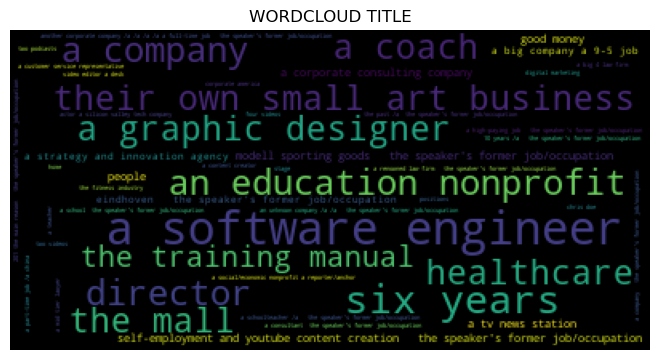

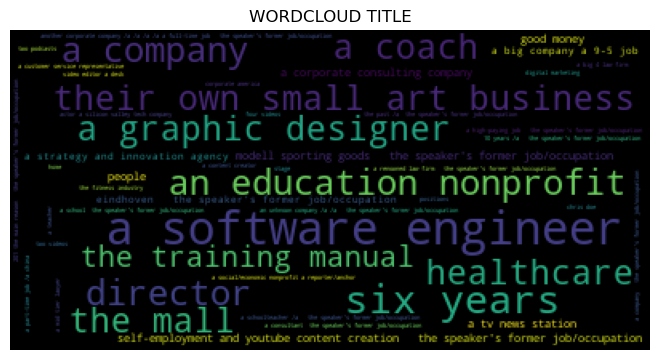

In [325]:
in_list = " ".join(full_df['main_reason_nc'].tolist()).replace("/a", "").split(".")
#input is string where . separate items to be counted

def make_wordcloud(in_column, sep_char = ".",word_count=50, title='WORDCLOUD TITLE'):
    """Return wordcloud matplotlib figure using a list of df column be counted and made into a frequency dictionary.
    
    Assume that in_column is a pd Series of list of strings where units to be counted are separated by 
    sep_char (can count words or phrases)
    
    """
    joined_string = " ".join(in_column)
    string_list = joined_string.split(sep_char)
    counter = collections.Counter(string_list)
    counts_dict = {}
    for word, count in counter.items():
        counts_dict[word] = count

    wordcloud = WordCloud(background_color='black',max_words=word_count,
                         stopwords=full_stopwords)
    wordcloud.generate_from_frequencies(frequencies=counts_dict)
    fig = plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.tight_layout(pad=0)

    return fig
make_wordcloud(full_df['former_job_nc'])

In [339]:
def make_barchart(in_column, sep_char = ".",word_count=50, title='BARCHART_TITLE'):
    """Return wordcloud matplotlib figure using a list of df column be counted and made into a frequency dictionary.
    
    Assume that in_column is a pd Series of list of strings where units to be counted are separated by 
    sep_char (can count words or phrases)
    
    """
    joined_string = " ".join(in_column)
    string_list = joined_string.split(sep_char)
    counter = collections.Counter(string_list)
    counts_dict = {}
    for word, count in counter.items():
        counts_dict[word] = count
    
    df = pd.DataFrame({'words': counts_dict.keys(),
                      "counts": counts_dict.values()}).sort_values(by='counts',ascending=False).iloc[:word_count]
    print(df.head())
    
    fig = px.bar(df, y='words', x='counts',title=title)
    return fig
    
make_barchart(full_df['transcript_nc'])

           words  counts
55        people    3991
2          a lot    3741
621     you guys    2285
37        things    2119
178   everything    1933


In [294]:

full_df.to_csv(out_filepath)


In [129]:
#OBS

# main_reasons = full_df['main_reason'].tolist()

# main_reason_nouns = []
# main_reason_adj = []
# for reason in main_reasons:
#     try:
#         text = TextBlob(reason) #TextBlob object
#         doc = nlp(reason) #spacy object
#         tokens = word_tokenize(reason)

#         noun_phrases = text.noun_phrases
#         noun_chunks = doc.noun_chunks
#         pos_tags = nltk.pos_tag(tokens)
# #         print(f"PHRASES:{noun_phrases}")
# #         print(f"CHUNKS:{[nc for nc in noun_chunks]}")

# #         nouns = " ".join([nc for nc in noun_chunks])
#         adjectives = [x[0] for x in pos_tags if x[1]=="JJ"]
#         adjectives = " ".join([str(x) for x in adjectives if x != 'main'])
# #         print(adjectives)
# #         print(nouns)
# #         main_reason_nouns.append(nouns)
#         main_reason_adj.append(adjectives)
# #         print(adjectives)
# #         print("_____")
# #         print(pos_tags)
            
#     except:
#         main_reason_adj.append("NA")
#         continue

In [131]:
# # for item in full_df['main_reason_adjectives'].tolist():
# #     print(type(item))
# " ".join(full_df['main_reason_adjectives'].tolist())

'nine-to-five overwhelmed anxious same  due mental understaffed  willing happy  physical worth own own own  stagnant nervous crazy physical psychological own nine-to-five  unhappy meaningful    new new  depressed unmotivated miserable   fast few bottom  multi-day difficult    creative  fear tired same  happy  same  full  stressful stable due  high new strong happy online free independent live incorrect due such regular weekly medical dental  overwhelmed much panic due   slight due other social  creative new strong  false other online free independent live happy worth former full-time  important expensive   mental finite own  right actual entrepreneurial  full-time entrepreneurial different RV friendly due high   adventurous amazing   other productive due such financial  low unhappy much  present new own financial new content corporate negative cognitive own due added pandemic financial due physical such unable straight own new westernized mental full-time entrepreneurial different RV f